# Load in dataset
A dataset was created in Create_dataset_for_training_MS2Query_model.ipynb. This dataset contains 4 dataframes with the scores for the top 2000 matches for each query spectrum in a validation and a training set. The scores are pasted after each other, so it can be used directly for training MS2Query models. 

In [16]:
from ms2query.utils import load_pickled_file
training_scores, training_labels, validation_scores, validation_labels = \
    load_pickled_file("../../downloads/gnps_210409/train_ms2query_model/ms2q_training_data.pickle")


# Select the top 100
The top 100 spectra are selected, to get a bit better distribution of tanimoto scores in training data

In [8]:
import pandas as pd
def select_less_top_spectra(nr_of_spectra_cut_off, dataframe_with_tanimoto_scores, dataframe_with_scores):
    nr_of_matches_per_training_spectra = 2000
    
    tanimoto_df_per_spectrum = []
    scores_df_per_spectrum = []
    for i in range(0, len(dataframe_with_scores), nr_of_matches_per_training_spectra):
        scores_for_one_spectrum = dataframe_with_scores.iloc[i:i+nr_of_spectra_cut_off]
        tanimoto_scores_one_spectrum = dataframe_with_tanimoto_scores.iloc[i:i+nr_of_spectra_cut_off]
        tanimoto_df_per_spectrum.append(tanimoto_scores_one_spectrum)
        scores_df_per_spectrum.append(scores_for_one_spectrum)
        
    selected_tanimoto_scores = pd.concat(tanimoto_df_per_spectrum)
    selected_scores = pd.concat(scores_df_per_spectrum)
    
    return selected_tanimoto_scores, selected_scores

(array([ 6.29767442, 14.35844961, 18.48434109, 15.93581395, 11.09085271,
         8.46387597,  4.84      ,  4.78666667,  5.74883721,  9.99348837]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

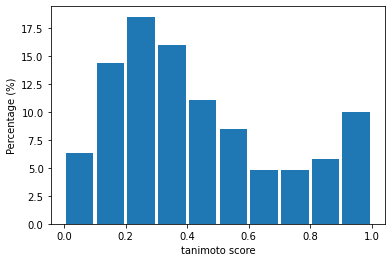

In [10]:
from matplotlib import pyplot as plt
 
training_labels_top_100, training_scores_top_100 = select_less_top_spectra(100, training_labels, training_scores)
validation_labels_top_100, validation_scores_top_100 = select_less_top_spectra(100, validation_labels, validation_scores)

weight_to_convert_to_percentage = 100/len(training_labels_top_100)
weights = [weight_to_convert_to_percentage] * len(training_labels_top_100)

plt.xlabel("tanimoto score")
plt.ylabel("Percentage (%)")
plt.hist(training_labels_top_100, weights = weights, rwidth = 0.9)

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
print(training_scores_top_100)

In [19]:
# train rf using optimised parameters from below
num_est = 250
rf = RandomForestRegressor(n_estimators = num_est, random_state = 42, max_depth = 5)
rf.fit(training_scores_top_100, training_labels_top_100)

# predict on train
rf_train_predictions = rf.predict(training_scores_top_100)
mse_train_rf = mean_squared_error(training_labels_top_100, rf_train_predictions)
print('Training MSE', mse_train_rf)

# predict on test
rf_predictions = rf.predict(validation_scores_top_100)
mse_rf = mean_squared_error(validation_labels_top_100, rf_predictions)
print('Validation MSE', mse_rf)

# get feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(training_scores_top_100.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

<ipython-input-19-1491944576e6>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(training_scores_top_100, training_labels_top_100)


Training MSE 0.03026257888622508
Validation MSE 0.030665551209559425
Variable: closely_related_inchikey14s_score Importance: 0.76
Variable: mass_similarity      Importance: 0.14
Variable: precursor_mz*0.001    Importance: 0.06
Variable: s2v_score            Importance: 0.02
Variable: ms2ds_score          Importance: 0.01
Variable: average_tanimoto_for_closely_related_score Importance: 0.01
Variable: average_ms2ds_score_for_inchikey14 Importance: 0.0
Variable: nr_of_spectra_with_same_inchikey14*0.01 Importance: 0.0
Variable: nr_of_spectra_for_closely_related_score*0.01 Importance: 0.0


[None, None, None, None, None, None, None, None, None]

In [26]:
training_scores_top_100 = training_scores_top_100.drop(["closely_related_inchikey14s_score"], axis = 1)
validation_scores_top_100 = validation_scores_top_100.drop(["closely_related_inchikey14s_score"], axis = 1)
# # train rf using optimised parameters from below
num_est = 250
rf = RandomForestRegressor(n_estimators = num_est, random_state = 42, max_depth = 5)
rf.fit(training_scores_top_100, training_labels_top_100)

# predict on train
rf_train_predictions = rf.predict(training_scores_top_100)
mse_train_rf = mean_squared_error(training_labels_top_100, rf_train_predictions)
print('Training MSE', mse_train_rf)

# predict on test
rf_predictions = rf.predict(validation_scores_top_100)
mse_rf = mean_squared_error(validation_labels_top_100, rf_predictions)
print('Validation MSE', mse_rf)

# get feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(training_scores_top_100.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Training MSE 0.03316396794257088
Validation MSE 0.03515624371765132
Variable: average_ms2ds_score_for_inchikey14 Importance: 0.54
Variable: mass_similarity      Importance: 0.13
Variable: precursor_mz*0.001    Importance: 0.12
Variable: ms2ds_score          Importance: 0.12
Variable: average_tanimoto_for_closely_related_score Importance: 0.08
Variable: s2v_score            Importance: 0.01
Variable: nr_of_spectra_with_same_inchikey14*0.01 Importance: 0.0
Variable: nr_of_spectra_for_closely_related_score*0.01 Importance: 0.0


[None, None, None, None, None, None, None, None]

In [29]:
training_scores_top_100 = training_scores_top_100[["s2v_score", "ms2ds_score"]]
validation_scores_top_100 = validation_scores_top_100[["s2v_score", "ms2ds_score"]]


validation_scores_top_100 = validation_scores_top_100
# train rf using optimised parameters from below
num_est = 250 
rf = RandomForestRegressor(n_estimators = num_est, random_state = 42, max_depth = 5)
rf.fit(training_scores_top_100, training_labels_top_100)

# predict on train
rf_train_predictions = rf.predict(training_scores_top_100)
mse_train_rf = mean_squared_error(training_labels_top_100, rf_train_predictions)
print('Training MSE', mse_train_rf)

# predict on test
rf_predictions = rf.predict(validation_scores_top_100)
mse_rf = mean_squared_error(validation_labels_top_100, rf_predictions)
print('Validation MSE', mse_rf)

# get feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(training_scores_top_100.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

<ipython-input-29-af263c063955>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(training_scores_top_100, training_labels_top_100)


Training MSE 0.04433748071763638
Validation MSE 0.0441256720996857
Variable: ms2ds_score          Importance: 0.89
Variable: s2v_score            Importance: 0.11


[None, None]